In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from __future__ import annotations

from glob import glob
import pickle

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
from tqdm.auto import tqdm

from voltplot import TIME_LABELS, TIME_TICKS, VoltPlot

# matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# hide top and right splines on plots
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [8]:
v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2
print(v_min, v_max)

y_min, y_max = 11.1, 13.4

129.96 158.76


In [9]:
# Recreate Fig8 in Qu and Li (2020)
# - they count the substation as bus 1
# - we count the substation as bus -1
index = [9, 19, 22, 31, 40, 46, 55]  # for us, we want to plot nodes [7, 17, etc.]

## Fig 7 - Nonlinear simulation - partial control
- ax1: nonlinear voltage profile at bus 19, many seeds
  - robust controller with $X^\star$
  - robust controller with CBC
- ax2: nonlinear voltage profile at bus 40, many seeds
  - robust controller with CBC + topology information for the first 14 buses 
  - robust controller with CBC + line (and thus topology) information for the first 14 buses 
- ax3: prediction error 
  - culmulative prediction error of robust controller, w/ $X^\star$
  - culmulative prediction error of robust controller, w/ CBC 
  - culmulative prediction error of robust controller, w/ CBC + topology information for the first 14 buses 
  - culmulative prediction error of robust controller, w/ CBC + line information for the first 14 buses 

In [31]:
def plot_fill(ax, values, color, label, alpha=False):
    """
    Args
    - values: shape [T, n]
    - color: int, index into tab20 colors
        0 = blue, 2 = orange, 4 = green, 7 = purple
    """
    T = values.shape[0]
    mean = values.mean(axis=1)
    std = values.std(axis=1)
    ts = range(T)
    dark = plt.cm.tab20.colors[color]
    light = plt.cm.tab20.colors[color + 1]
    ax.plot(ts, mean, color=dark, lw=0.5, label=label)
    if alpha:
        ax.fill_between(ts, mean-std, mean+std, color=light, alpha=0.5)
    else:
        ax.fill_between(ts, mean-std, mean+std, color=light)

## Nonlinear Partial Control: $X^*$ vs. adaptive vs adaptive + topo info

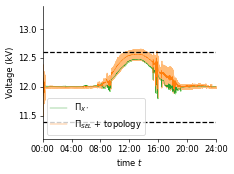

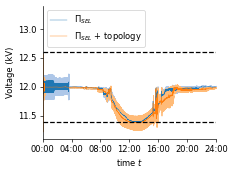

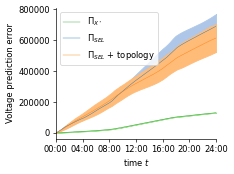

In [67]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

bus1 = 17 # bus 19
bus2 = 29 # bus 31


# # fixed X^*
T = 14421
label = '$\Pi_{X^\star}$'
ro_bus1 = np.zeros([T, 4])
ro_bus2 = np.zeros([T, 4])
pred_error = np.zeros([T,4])

paths = list(filter(
    lambda x: 'Pu' not in x,
    glob('out-nonlinear-partial2/CBCproj_noise1.0_perm_norm1.0_*_fullctrl_fixed*.pkl'))) # even though the name is "fullctrl", it actually is the partial control fixed controller
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    ro_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    ro_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    temp_list = data['pred_error']['fixed_optimal_linear']
    temp_list.insert(0,0.0)
    pred_error[:,i] = np.cumsum(np.array(temp_list))

plot_fill(ax=axs[0], values=ro_bus1, color=4, label=label)
plot_fill(ax=axs[2], values=pred_error, color=4,label=label)


# CBC
label = '$\Pi_{SEL}$'
ro_bus1 = np.zeros([T, 4])
ro_bus2 = np.zeros([T, 4])
pred_error = np.zeros([T,4])

paths = list(filter(
    lambda x: 'Pu' not in x,
    glob('out-nonlinear-partial-small-extra/CBCproj_noise1.0_perm_norm1.0_*_partialctrl_adaptive_2*.pkl'))) 
#     glob('out/CBCproj_noise1.0_perm_norm1.0_*_partialctrl_topo14line0*.pkl')))
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    ro_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    ro_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    temp_list = data['pred_error']['adaptive_linear']
    temp_list.insert(0,0.0)
    pred_error[:,i] = np.cumsum(np.array(temp_list))
    
# plot_fill(ax=axs[0], values=ro_bus1, color=0, label=label)
plot_fill(ax=axs[1], values=ro_bus2, color=0, label=label)
plot_fill(ax=axs[2], values=pred_error, color=0,label=label)


# # CBC + line information
# label = '$\Pi_{SEL}$ + line'
# ro_bus1 = np.zeros([T, 4])
# ro_bus2 = np.zeros([T, 4])
# pred_error = np.zeros([T,4])

# paths = list(filter(
#     lambda x: 'Pu' not in x,
#     glob('out/CBCproj_noise1.0_perm_norm1.0_*_partialctrl_topo14line14*.pkl')))
# for i, path in enumerate(paths):
#     with open(path, 'rb') as f:
#         data = pickle.load(f)
#     ro_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
#     ro_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
#     temp_list = data['pred_error']['adaptive_linear']
#     temp_list.insert(0,0.0)
#     pred_error[:,i] = np.cumsum(np.array(temp_list))
    
# plot_fill(ax=axs[1], values=ro_bus2, color=7, label=label)
# plot_fill(ax=axs[2], values=pred_error, color=7,label=label)


# CBC + topology information
label = '$\Pi_{SEL}$ + topology'
rocbc_bus1 = np.zeros([T, 4])
rocbc_bus2 = np.zeros([T, 4])
pred_error = np.zeros([T,4])


paths = list(filter(
    lambda x: 'Pu' not in x,
    glob('out-nonlinear-partial-small-extra/CBCproj_noise1.0_perm_norm1.0_*_partialctrl_adaptive_topo14line14*.pkl')))

for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    rocbc_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    rocbc_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    temp_list = data['pred_error']['adaptive_linear']
    temp_list.insert(0,0.0)
    pred_error[:,i] = np.cumsum(np.array(temp_list))

plot_fill(ax=axs[0], values=rocbc_bus1, color=2, label=label)
plot_fill(ax=axs[1], values=rocbc_bus2, color=2, label=label)
plot_fill(ax=axs[2], values=pred_error, color=2,label=label)


# plot proporties
for ax in [axs[0], axs[1]]:
    ax.axhline(11.4, ls='--', color='black')
    ax.axhline(12.6, ls='--', color='black')
    ax.set_ylabel('Voltage (kV)')
    ax.set_ylim(y_min, y_max)
axs[2].set_ylabel('Voltage prediction error')

axs[0].legend(loc='lower left')
axs[1].legend(loc='upper left')
axs[2].legend()

for ax in axs:
    ax.set_xticks(TIME_TICKS)
    ax.set_xticklabels(TIME_LABELS)
    ax.set_xlim(0, T)
    ax.set_xlabel('time $t$')

for i, fig in enumerate(figs):
    fig.savefig(f'out-nonlinear-partial-small-extra/nonlinear_{i}.pdf', bbox_inches='tight', dpi=200, pad_inches=0)
    fig.savefig(f'out-nonlinear-partial-small-extra/nonlinear_{i}.png', bbox_inches='tight', dpi=200, pad_inches=0)

In [57]:
paths = list(filter(
    lambda x: 'Pu' not in x,
    glob('out-nonlinear-partial2/CBCproj_noise1.0_perm_norm1.0_*_partialctrl_adaptive_2*.pkl')))
print(paths)
len(paths)


['out-nonlinear-partial2/CBCproj_noise1.0_perm_norm1.0_seed10_partialctrl_adaptive_20230322_201843.pkl', 'out-nonlinear-partial2/CBCproj_noise1.0_perm_norm1.0_seed11_partialctrl_adaptive_20230322_204216.pkl', 'out-nonlinear-partial2/CBCproj_noise1.0_perm_norm1.0_seed9_partialctrl_adaptive_20230322_200359.pkl', 'out-nonlinear-partial2/CBCproj_noise1.0_perm_norm1.0_seed8_partialctrl_adaptive_20230322_183902.pkl']


4

## Nonlinear Full Control: $X^*$ vs. adaptive vs adaptive + topo info vs adaptive + line info

## Fig 6 - Nonlinear Baseline - partial control
- ax1: nonlinear voltage profile, no controller
- ax2: nonlinear voltage profile MPC with true X
- ax3: nonlinear voltage profile MPC with CBC
- ax4: nonlinear voltage profile MPC with CBC + line and topology information


In [68]:
from network_utils import (
    create_56bus,
    create_RX_from_net,
    read_load_data)

net = create_56bus()
R, X = create_RX_from_net(net, noise=0)  # true R and X
p, qe = read_load_data()  # in MW and MVar
T, n = p.shape

v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
v_sub = v_nom  # fixed squared voltage magnitude at substation, units kV^2

vpars = qe @ X + p @ R + v_sub  # shape [T, n]

vpars_nonlinear = np.load('nonlinear_voltage_baseline.npy')
vpars_nonlinear = (vpars_nonlinear*12.)**2

In [61]:
# Open files

path_fixed = 'out/CBCproj_noise1.0_perm_norm1.0_seed11_partialctrl_fixed_20230307_015219.pkl'
path_adaptive = 'out/CBCproj_noise1.0_perm_norm1.0_seed11_partialctrl_20230307_004504.pkl'
path_adaptive_topo = 'out/CBCproj_noise1.0_perm_norm1.0_seed11_partialctrl_topo14line14_20230307_152158.pkl'

with open(path_adaptive, 'rb') as f:
    data_adaptive = pickle.load(f)
with open(path_adaptive_topo, 'rb') as f:
    data_adaptive_topo = pickle.load(f)
with open(path_fixed, 'rb') as f:
    data_fixed = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'out/CBCproj_noise1.0_perm_norm1.0_seed11_partialctrl_20230307_004504.pkl'

In [ ]:
data_adaptive['vs'][:,1].shape

In [ ]:
figs, axs = zip(*[
    plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    for _ in range(4)])

# axs[0].set_title('Voltage Profile, no Controller')
# axs[1].set_title('Voltage Profile, Robust Controller with $X^\star$')

ts = range(T)
for i in np.asarray(index) - 2:
    axs[0].plot(ts, np.sqrt(vpars_nonlinear[:, i]))
    axs[2].plot(ts, np.sqrt(data_adaptive['vs'][:, i]), label=f'bus {i+2}')
#     axs[1].plot(ts, np.sqrt(vpars[:, i]))
    axs[3].plot(ts, np.sqrt(data_adaptive_topo['vs'][:, i]), label=f'bus {i+2}')
    axs[1].plot(ts, np.sqrt(data_fixed['vs'][:, i]), label=f'bus {i+2}')

for ax in axs:
    ax.set_xticks(TIME_TICKS)
    ax.set_xticklabels(TIME_LABELS)
    ax.axhline(11.4, ls='--', color='black')
    ax.axhline(12.6, ls='--', color='black')
    ax.set(xlabel='time $t$', ylabel='Voltage (kV)')
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, T)

for fig, tag in zip(figs, ['a', 'b', 'c', 'd']):    
    fig.savefig(f'out-nonlinear-partial2/non_baselines_{tag}.pdf', bbox_inches='tight', dpi=200, pad_inches=0)
    fig.savefig(f'out-nonlinear-partial2/non_baselines_{tag}.png', bbox_inches='tight', dpi=200, pad_inches=0)

leg = axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
figs[3].canvas.draw()
bbox = leg.get_window_extent().transformed(figs[3].dpi_scale_trans.inverted())
figs[3].savefig('out-nonlinear-partial2/non_baselines_legend.pdf', dpi=200, bbox_inches=bbox)